<a href="https://colab.research.google.com/github/justincharney/Autoencoder_And_Denoiser_Pytorch/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Convolutional Autencoder and Denoising Autencoder**

In [ ]:
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms


**Defining the architecture for the Denoiser**

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 32, kernel_size= 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 16, kernel_size= 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride = 2)
        self.output = nn.Conv2d(32,1, kernel_size= 3, padding=1)


    def forward(self, x):
        ## encode ##
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        ## decode ##
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = torch.sigmoid(self.output(x))
                
        return x

# initialize the neural network
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (t_conv2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (output): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder,self).__init__()
    #Encoder
    self.conv1 = nn.Conv2d(1,16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(16,4, kernel_size=3,padding=1)
    self.pool = nn.MaxPool2d(2,2)

    #Decoder
    self.t_conv1 = nn.ConvTranspose2d(4,16,kernel_size=2,stride=2)
    self.t_conv2 = nn.ConvTranspose2d(16,1,kernel_size=2,stride=2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.t_conv1(x))
    x = torch.sigmoid(self.t_conv2(x))
    return x
  
model_2 = AutoEncoder()
print(model_2)

AutoEncoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [ ]:
#defining some parameters
num_epochs = 20
batch_size = 20

criterion = nn.MSELoss()
criterion2 = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
optimizer2 = torch.optim.Adam(model_2.parameters(), lr = 0.001)

In [ ]:
# getting and preparing data

transform = transforms.ToTensor()

train_data = datasets.MNIST(root = "data", train = True, download=True, 
                            transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
num_workers = 0
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

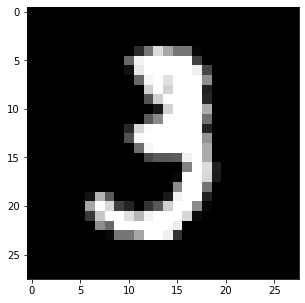

In [ ]:
# visualizing the data

import matplotlib.pyplot as plt
import random

#one batch of training data
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

#one image from the batch
img = np.squeeze(images[random.randint(1,10)])
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = "gray")





# **TRAINING THE DENOISER. DO NOT NEED TO DO THIS AGAIN, SIMPLY RUN CELLS UNTIL THIS POINT**

In [ ]:
#Training denoising Autoencoder

noise = 0.5

for epoch in range(num_epochs):
  train_loss = 0
  loss_values = []
  for data in train_loader:
    image, _ = data
    noisy_image = image + noise * torch.randn(*image.shape)
    noisy_image = np.clip(noisy_image, 0., 1.)
    

    optimizer.zero_grad()
    outputs = model(noisy_image)
    loss = criterion(outputs, image)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * image.size(0)

  train_loss = train_loss/len(train_loader)
  loss_values.append(train_loss)
  print("Epoch {} \t Training Loss {:.6f}".format (epoch, train_loss))



# **TRAINING THE AUTOENCODER. DO NOT NEED TO DO THIS AGAIN.**

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
  train_loss = 0
  for data in train_loader:
    images, _ = data

    optimizer2.zero_grad()
    outputs = model_2(images)
    loss2 = criterion2(outputs, images)
    loss2.backward()
    optimizer2.step()
    train_loss += loss2.item()*images.size(0)

  train_loss = train_loss/len(train_loader)
  print("Epoch {} \t Training Loss {:.6f}".format (epoch, train_loss))


Epoch 0 	 Training Loss 0.514328
Epoch 1 	 Training Loss 0.274733
Epoch 2 	 Training Loss 0.260350
Epoch 3 	 Training Loss 0.251932
Epoch 4 	 Training Loss 0.246260
Epoch 5 	 Training Loss 0.242224
Epoch 6 	 Training Loss 0.238925
Epoch 7 	 Training Loss 0.236047
Epoch 8 	 Training Loss 0.232862
Epoch 9 	 Training Loss 0.228232
Epoch 10 	 Training Loss 0.224865
Epoch 11 	 Training Loss 0.222225
Epoch 12 	 Training Loss 0.219842
Epoch 13 	 Training Loss 0.217520
Epoch 14 	 Training Loss 0.215346
Epoch 15 	 Training Loss 0.212971
Epoch 16 	 Training Loss 0.210653
Epoch 17 	 Training Loss 0.208783
Epoch 18 	 Training Loss 0.207175
Epoch 19 	 Training Loss 0.205798


**Code to save and Load Autoencoder**

In [ ]:
#torch.save(model_2.state_dict(), "Autoencoder")

# model_2.load_state_dict(torch.load("Autoencoder"))

**Code to save and load denoiser**

In [ ]:
#torch.save(model.state_dict(),"Autoencoder-Denoiser")

# model.load_state_dict(torch.load("Autoencoder-Denoiser"))

# **Implemenatation and testing**

**Testing the autoencoder**

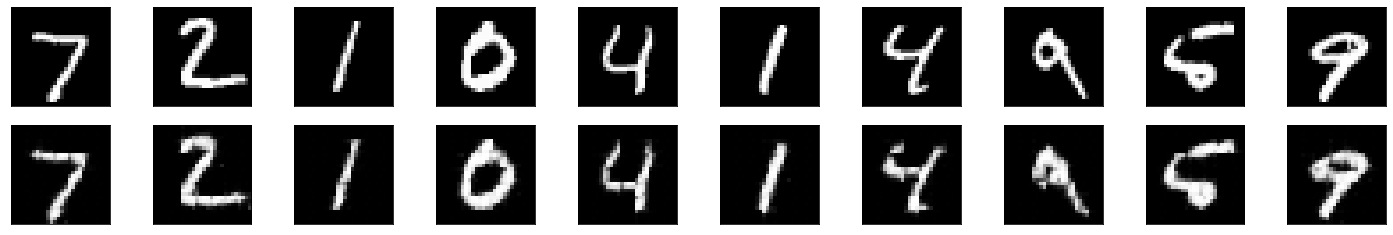

In [ ]:
#For regular Autencoder
dataiter = iter(test_loader)
images, labels = dataiter.next()
model_2 = AutoEncoder()
model_2.load_state_dict(torch.load("Autoencoder"))

output = model_2(images)
images = images.numpy()
output = output.view(batch_size,1,28,28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# Original images on top, reconstructed images on the bottom
for images, row in zip([images, output], axes):
  for img, ax in zip(images, row):
    ax.imshow(np.squeeze(img), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

**Testing the denoiser**

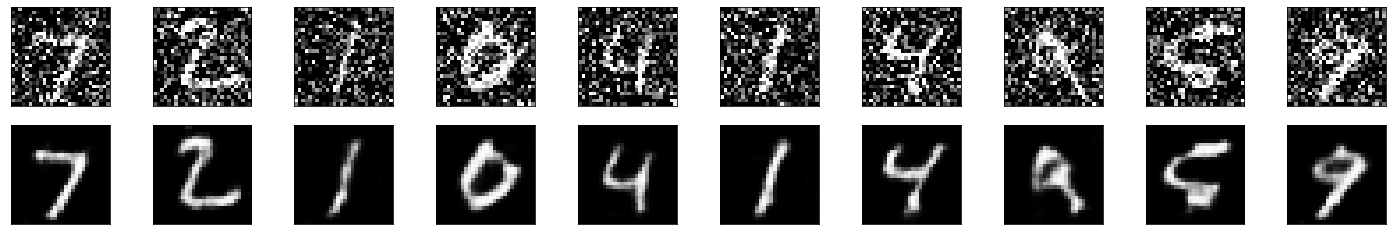

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

noise = 0.5

noisy_image = images + noise *torch.randn(images.shape)
noisy_image = np.clip(noisy_image, 0., 1.)

model = ConvAutoencoder()
model.load_state_dict(torch.load("Autoencoder-Denoiser"))

output = model(noisy_image)
noisy_image = noisy_image.numpy()

output = output.view(batch_size,1,28,28)
output = output.detach().numpy()

fig,axes = plt.subplots(nrows=2,ncols=10,sharex=True, sharey=True, figsize=(25,4))

for noisy_image, row in zip([noisy_image,output], axes):
  for image, ax in zip(noisy_image,row):
    ax.imshow(np.squeeze(image), cmap = "gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)